In [1]:
import scipy.special as scis
import numpy as np
from statistics import mean
from numpy import linalg as la
from matplotlib import pyplot as plt
from math import pi,exp
from math import sqrt as sq

In [2]:
from numba import jit

In [3]:
def T22(k,x,xi,ni):
    r_ = la.norm(x-xi)
    D = k*r_ * scis.hankel2(1,k*r_)
    return 1j/(4*r_) * D * gam_k__n_k(x,xi,ni)

In [4]:
def G22(k,x,xi,beta,rho):
    r_ = la.norm(x-xi)
    return 1/(1j*4*rho) * scis.hankel2(0,k*r_)/beta**2

In [5]:
def gam_k__n_k(x,xi,ni):
    r_ = la.norm(x-xi)
    return (x[0]-xi[0])/r_ * ni[0] + (x[1]-xi[1])/r_ * ni[1]

In [6]:
T= 2 # seg
N= 64 # armonicos
dt=0.05
f0=1/T
fmax=1/(2*dt)
df=1/(N*dt)
frec=np.r_[f0:fmax:df]

In [7]:
len(frec),fmax,df,f0

(31, 10.0, 0.3125, 0.5)

In [8]:
w = 2*pi*frec # rad/s
beta = 2500 # km/s

In [9]:
lambds = beta/frec # long de onda en kilometros
ks = w / beta # 1/km
rho = 2500
mus = beta**2 * rho # 2nd Lame constant

In [10]:
dxs=lambds/16

In [11]:
# fuente puntual (antiplana) en
XI = np.array([5000.0,-50.0])
# receptor 
XX =  np.array([5000.0,-25.0])

In [12]:
L=10000;
chunks=np.round(L/dxs).astype(int)

In [13]:
def malla(chunk):
    vert=np.zeros((chunk,2))
    vert[:,0]=np.linspace(0,L,chunk)
    xis=0.5*(vert[1:]+vert[:-1])
    a=vert[1:]-vert[:-1]
    norms=la.norm(a,axis=1)
    nu=np.zeros_like(a)
    nu[:,0]=-a[:,1]/norms
    nu[:,1]=a[:,0]/norms
    return vert,xis,nu

In [14]:
def Int_T22_uniforme_en_xi(n,l,k,vert,xis,norm):
    if n==l:
        return 0.0
    
    gau_i=[-0.774597,0,0.774597]
    w_i=[0.555556,0.888889,0.555556]
    
    b=vert[l,0];a=vert[l+1,0]; 
    xi_x_gau=[(b-a)/2*gau+(a+b)/2 for gau in gau_i]
    
    b=vert[l,1];a=vert[l+1,1]; 
    xi_z_gau=[(b-a)/2*gau+(a+b)/2 for gau in gau_i]
    
    Xi_gau=[[xi_x_gau[i],xi_z_gau[i]] for i in range(len(gau_i))]
    Xi_gau=np.array(Xi_gau)
    
    L=la.norm(vert[l]-vert[n])
    Int=0.0
    for i in range(len(gau_i)):
        Int += L/2 * w_i[i]*T22(k,xis[n],Xi_gau[i],norm[n])
    return Int

In [15]:
def Solver(k,vert,xis,nu):
    # para cada punto de colocacion (renglon)
    #, la integral de las fuentes sobre la superficie
    Mat=np.zeros([len(xis),len(xis)])
    Mat = Mat + 0j*Mat
    for n in range(len(xis)):
        for l in range(len(xis)):
            if n==l:
                Mat[n,l]=0.5+0j
            else:
                Mat[n,l]=Int_T22_uniforme_en_xi(n,l,k,vert,xis,nu)
                
                
    # fuente
    Fue=np.zeros([len(xis),1])
    Fue = Fue + 0j*Fue
    for l in range(len(xis)):
        Fue[l]=T22(k, xis[l], XI, nu[l])
        
    # encontrar amplitudes phi de la densidad de fuerza: phi dS
    phi = np.linalg.solve(Mat,-Fue)
    
    #phis=[abs(phi[i]) for i in range(len(xis))]
    #plt.scatter(xis[:,0],phis,color='black')
    #plt.show()
    
    return phi

In [16]:
def Desplazamiento_Por_frec(data):
    k,vert,xis,nu,XX,beta,rho=data
    phi=Solver(k,vert,xis,nu)
    V = G22(k,XX,XI,beta,rho)
    for i_xi in range(len(xis)):
        V+=phi[i_xi]*G22(k,XX,xis[i_xi,:],beta,rho)

    return V

In [17]:
#@jit(fastmath=True,forceobj=True)
def IBEM(chunks,ks):
    espectro=[]
    for Iele in range(len(ks)):
        vert,xis,nu=malla(chunks[Iele])
        datos=(ks[Iele],vert,xis,nu,XX,beta,rho)
        espectro.append(Desplazamiento_Por_frec(datos))
    e=np.array(espectro[1:])
    e=np.conj(e)
    e=e.tolist()
    espectro+=e
        
    return espectro

In [18]:
def signal(chunks,ks):
    sp=IBEM(chunks,ks)
    # Cálculo de la IFFT para recuperar la señal en el dominio del tiempo
    señal_recuperada = np.fft.ifft(sp)
    
    return señal_recuperada

In [19]:
señal=signal(chunks,ks)

C:\Users\jcossc\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


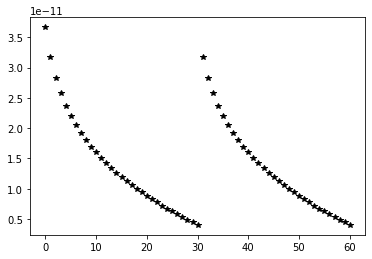

In [20]:
plt.plot(señal,'*k')
plt.show()

In [21]:
"""import numpy as np
import matplotlib.pyplot as plt

# Señal de entrada (en el dominio del tiempo)
t = np.linspace(0, 2*np.pi, 1000, endpoint=False)  # Vector de tiempo
frecuencia = 5  # Frecuencia de la señal
señal_entrada = np.sin(2 * np.pi * frecuencia * t)  # Señal sinusoidal de frecuencia 5 Hz

# Cálculo de la FFT
fft_resultado = np.fft.fft(señal_entrada)

# Cálculo de la IFFT para recuperar la señal en el dominio del tiempo
señal_recuperada = np.fft.ifft(fft_resultado)

# Gráfico de la señal recuperada
plt.figure(figsize=(10, 6))
plt.plot(t, señal_recuperada.real, label='Señal recuperada')
plt.plot(t, señal_entrada, label='Señal original', linestyle='--')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Señal recuperada mediante IFFT')
plt.legend()
plt.grid(True)
plt.show()"""

"import numpy as np\nimport matplotlib.pyplot as plt\n\n# Señal de entrada (en el dominio del tiempo)\nt = np.linspace(0, 2*np.pi, 1000, endpoint=False)  # Vector de tiempo\nfrecuencia = 5  # Frecuencia de la señal\nseñal_entrada = np.sin(2 * np.pi * frecuencia * t)  # Señal sinusoidal de frecuencia 5 Hz\n\n# Cálculo de la FFT\nfft_resultado = np.fft.fft(señal_entrada)\n\n# Cálculo de la IFFT para recuperar la señal en el dominio del tiempo\nseñal_recuperada = np.fft.ifft(fft_resultado)\n\n# Gráfico de la señal recuperada\nplt.figure(figsize=(10, 6))\nplt.plot(t, señal_recuperada.real, label='Señal recuperada')\nplt.plot(t, señal_entrada, label='Señal original', linestyle='--')\nplt.xlabel('Tiempo')\nplt.ylabel('Amplitud')\nplt.title('Señal recuperada mediante IFFT')\nplt.legend()\nplt.grid(True)\nplt.show()"